In [1]:
'''Path to LIBRARIES '''
import os, sys
LibPath = '../'
if LibPath in sys.path:
    print('YES')
else:
    print('NO, we\'ll add it now')
    sys.path.append(LibPath)
import warnings
warnings.filterwarnings("ignore")

NO, we'll add it now


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from Libraries.Spectrum import MSSAUse, MSSAExplore
from Libraries.NeurosV import LSTMUseV
from Libraries.Tests import ChoosePredsCCor
from Libraries.Util import Norm01, Metr

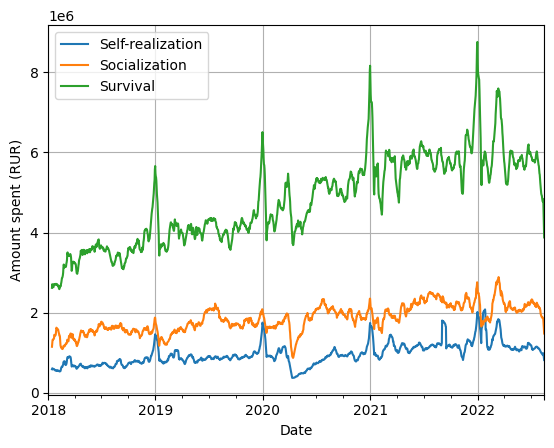

In [3]:
'''Target series to forecast '''
data=pd.read_csv('sssr.csv', parse_dates=['idate'])
data.set_index('idate', inplace=True)
data.drop('money', axis=1).rolling(14).mean().plot(grid=True)
plt.xlabel('Date')
plt.ylabel('Amount spent (RUR)')
plt.legend(['Self-realization', 'Socialization', 'Survival'])
plt.savefig('data.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()

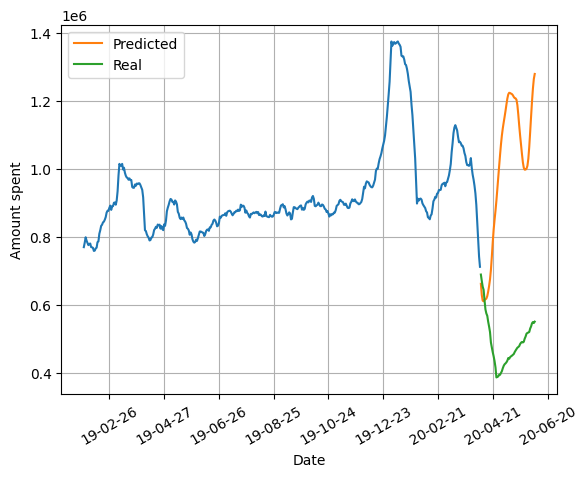

111.4


In [4]:
#x0 day when forecasting starts, 
#fwd - forecast horizon 
#smwin - rolling window size for smoothing, 
#value - name of the series to forecast, 
#dshift - how many days to drop in the befinning of the series
x0, fwd, smwin, value, dshift  = 800, 60, 28, 'self_realization', 365
dat=data[value].rolling(smwin).mean().dropna().values
y=MSSAUse(dat[x0-700:x0], fwd, prds=[], predictors=None)
x=np.arange(x0, x0+fwd)-dshift
xt=np.arange(smwin+dshift, x0+fwd+smwin, 60)-dshift
plt.plot(dat[dshift:x0])
plt.plot(x, y, label='Predicted')
plt.plot(x, dat[x0:x0+fwd], label='Real')
plt.xticks(xt, data.index.strftime('%y-%m-%d')[xt+dshift+smwin], rotation=30)
plt.xlabel('Date')
plt.ylabel('Amount spent')
plt.legend()
plt.grid()
plt.savefig('MSSA_no_news.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
print(Metr(y, dat[x0:x0+fwd])[2].round(1))    

<AxesSubplot:>

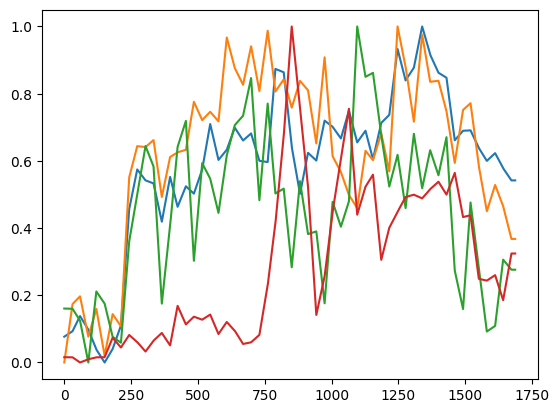

In [5]:
'''News topics embedded into time-series'''
topics=pd.read_csv('TOPICS.csv')
topics.rename(columns={'Unnamed: 0':'date'}, inplace=True)
tpc=pd.DataFrame()
tpc['date']=list(data.index.strftime('%Y-%m-%d'))
x=np.arange(len(data))[np.in1d(np.array(data.index.strftime('%Y-%m-%d')), topics.date.values)]
for c in topics.columns[1:]:
    tpc[c]=np.interp(np.arange(len(data)), x, topics[c].values)
    tpc[c]=Norm01(tpc[c].values)[0]
tpc[tpc.columns[:5]].plot(legend=False)   

In [6]:
'''Topics selection by means of tests '''
from Libraries.Tests import ChoosePredsGran, ChoosePredsCCM
clmn=tpc.columns[:]
dat=data.rolling(smwin).mean().dropna()
data['week']=data.index.strftime('%Y-%m-%d') #[smwin-1:]data.rename(columns={value:'data'})[100:x0]
prds=ChoosePredsCCor(pd.DataFrame({'week':data.index[x0-300+fwd:x0+fwd].strftime('%Y-%m-%d'), 'data':dat[value][x0-300:x0]}), tpc[clmn].rename(columns={'date':'week'})[x0-300:x0], len(c), maxlag=15)

In [7]:
'''Selected predictors'''
for i in prds:
    print(i['prd'], i['lag'], i['score'].round(2))

5_мотоциклис_велосипеди_велосипед 3 0.82
1_полиция_полицейски_наркотик 13 0.8
47_треугольни_красный_пожар 1 0.71
10_кафе_ресторан_кофе 14 0.71
16_афганистан_мусульмани_азербайджа 9 0.69
24_природопол_экологичес_комитет 1 0.69
3_год_2022_2020 1 0.67
33_tele2_абонент_лентв24 14 0.66
0_петербург_россия_рассказыва 10 0.66
46_оповещение_система_проверка 1 0.65
14_операция_онлайн_военный 4 0.65
43_четырехдне_рабочий_неделя 1 0.63
8_qr_код_цифровой 14 0.58
17_граффити_художник_закрашиват 1 0.57
23_венесуэла_мадуро_сша 14 0.56
30_гидрометце_европейски_погода 1 0.56
38_замок_михайловск_башня 1 0.56
45_страховой_страховщик_страховка 1 0.53
15_психолог_депрессия_психиатр 1 0.52
9_маска_носить_медицински 14 0.5
27_интеллект_искусствен_пластическ 1 0.49
42_коррупция_борьба_коррупцион 14 0.47
12_эстония_голландия_новый 13 0.46
18_медведь_пиво_медвежонок 1 0.43
35_импорт_экспорт_параллельн 14 0.42
44_интернацио_парк_референдум 1 0.38
13_учитель_учительниц_математика 14 0.37
37_коммунист_хакасия_выбор

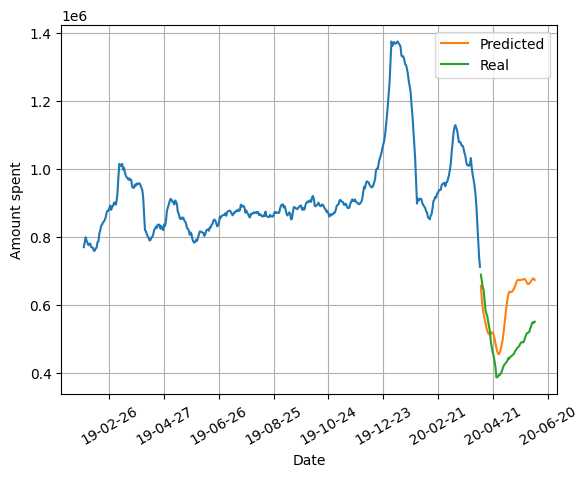

25.3


In [8]:
'''Forecast with selected predictors'''
dat=data[value].rolling(smwin).mean().dropna().values
y=MSSAUse(dat[x0-700:x0], fwd, prds=prds[0:5], predictors=tpc[x0-700:x0])
x=np.arange(x0, x0+fwd)-dshift
xt=np.arange(smwin+dshift, x0+fwd+smwin, 60)-dshift
plt.plot(dat[dshift:x0])
plt.plot(x, y, label='Predicted')
plt.plot(x, dat[x0:x0+fwd], label='Real')
plt.xticks(xt, data.index.strftime('%y-%m-%d')[xt+dshift+smwin], rotation=30)
plt.xlabel('Date')
plt.ylabel('Amount spent')
plt.legend()
plt.grid()
plt.savefig('MSSA_with_news.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
print(Metr(y, dat[x0:x0+fwd])[2].round(1))

800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 

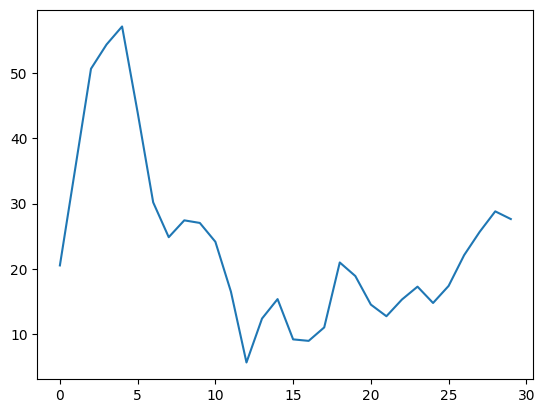

In [9]:
'''MSSA Forecast errors by day of its beginning (predictors in use)'''
mapes=[]
for i in range(x0, x0+30):
    print(i, end=' ')
    mapes.append(MSSAExplore(dat[100:1000], fwd, split=1000-i, prds=prds[:5], predictors=tpc[100:1000])[2])
plt.plot(mapes)

800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 

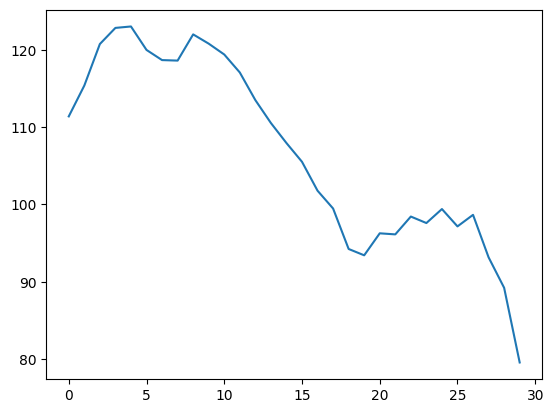

In [10]:
'''Forecast errors by day of its beginning (no predictors in use)'''
mapes0=[]
for i in range(x0, x0+30):
    print(i, end=' ')
    mapes0.append(MSSAExplore(dat[100:1000], fwd, split=1000-i, prds=[], predictors=None)[2])
plt.plot(mapes0)

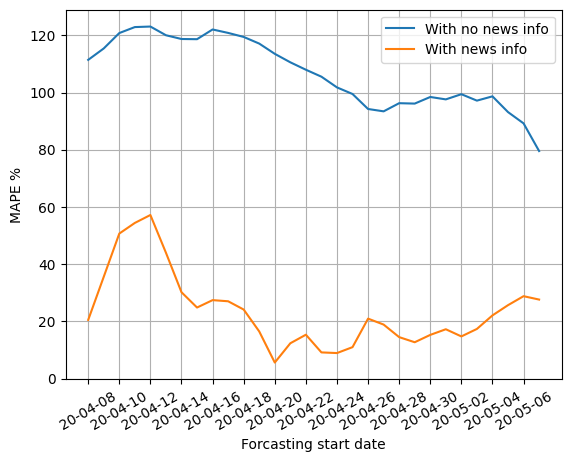

In [11]:
'''Plot it'''
xt=np.arange(x0+smwin, x0+smwin+30, 2)
plt.plot(mapes0, label='With no news info')
plt.plot(mapes, label='With news info')
plt.xticks(xt-x0-smwin, data.index.strftime('%y-%m-%d')[xt], rotation=30)
plt.xlabel('Forcasting start date')
plt.ylabel('MAPE %')
plt.legend()
plt.grid()
plt.savefig('mapes_dates.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()


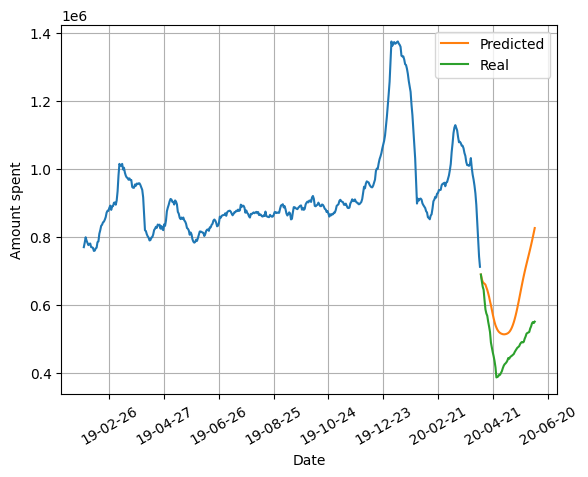

26.3


In [12]:
'''The same with Vector Autoregression''' 
from Libraries.Autoregr import VARUse, VARExplore
dat=data[value].rolling(smwin).mean().dropna().values
y=VARUse(dat[x0-200:x0], fwd, prds=prds[:5], predictors=tpc[x0-200:x0]) #predictors ON
#y=VARUse(dat[x0-200:x0], fwd, prds=[], predictors=None) #predictors OFF

x=np.arange(x0, x0+fwd)-dshift
xt=np.arange(smwin+dshift, x0+fwd+smwin, 60)-dshift
plt.plot(dat[dshift:x0])
plt.plot(x, y, label='Predicted')
plt.plot(x, dat[x0:x0+fwd], label='Real')
plt.xticks(xt, data.index.strftime('%y-%m-%d')[xt+dshift+smwin], rotation=30)
plt.xlabel('Date')
plt.ylabel('Amount spent')
plt.legend()
plt.grid()
#plt.savefig('VAR_with_news.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
print(Metr(y, dat[x0:x0+fwd])[2].round(1))

800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 

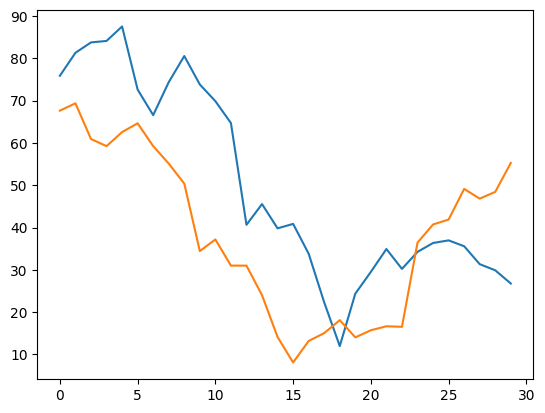

In [13]:
vmapes=[]
vmapes0=[]
dat=data[value].rolling(smwin).mean().dropna().values
for i in range(x0, x0+30):
    print(i, end=' ')
    vmapes.append(VARExplore(dat[x0-300:1000], fwd, split=1000-i, prds=prds[:1], predictors=tpc[x0-300:1000])[2])
    vmapes0.append(VARExplore(dat[x0-300:1000], fwd, split=1000-i, prds=[], predictors=None)[2])
plt.plot(vmapes0)
plt.plot(vmapes)

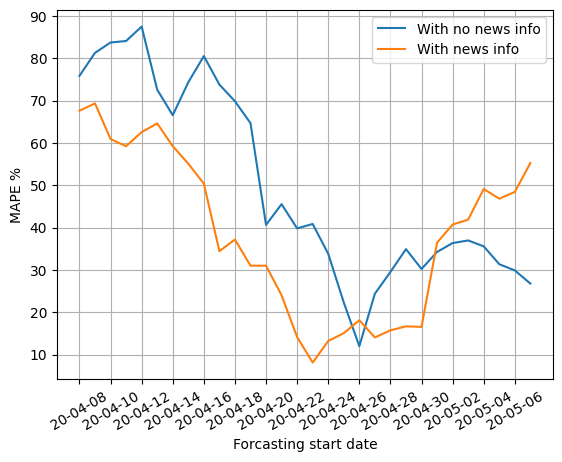

In [14]:
xt=np.arange(x0+smwin, x0+smwin+30, 2)
plt.plot(vmapes0, label='With no news info')
plt.plot(vmapes, label='With news info')
plt.xticks(xt-x0-smwin, data.index.strftime('%y-%m-%d')[xt], rotation=30)
plt.xlabel('Forcasting start date')
plt.ylabel('MAPE %')
plt.legend()
plt.grid()
plt.savefig('VARmapes_dates.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()

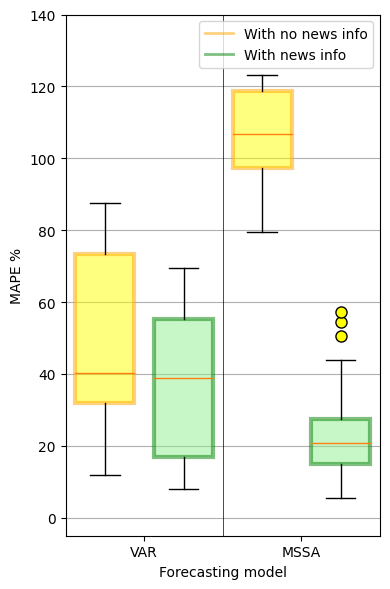

In [15]:
boxprops0 = dict(linewidth=3, color='orange', facecolor = 'yellow', alpha=.5)
boxprops1 = dict(linewidth=3,  color='green', facecolor = 'lightgreen', alpha=.5)
boxprops = [boxprops0, boxprops1]
flierprops = dict(marker='o', markerfacecolor='yellow', markersize=8, linestyle='none')
plt.figure(figsize=(4,6))
for i, j in enumerate([vmapes0, vmapes, mapes0, mapes]):
    plt.boxplot([j], positions = [i+1], widths=0.75, boxprops=boxprops[i%2], flierprops=flierprops, patch_artist=True, vert=True)
plt.xticks([1.5,3.5], ['VAR','MSSA'])
plt.xlabel('Forecasting model')
plt.plot([], c='orange',lw=2,alpha=.5, label='With no news info')
plt.plot([], c='green',lw=2, alpha=.5, label='With news info')
plt.legend()
plt.axvline(2.5, c='k', lw=.5)
plt.ylabel('MAPE %')
plt.ylim(-5, 140)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('mapes_boxes.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()

For 2022

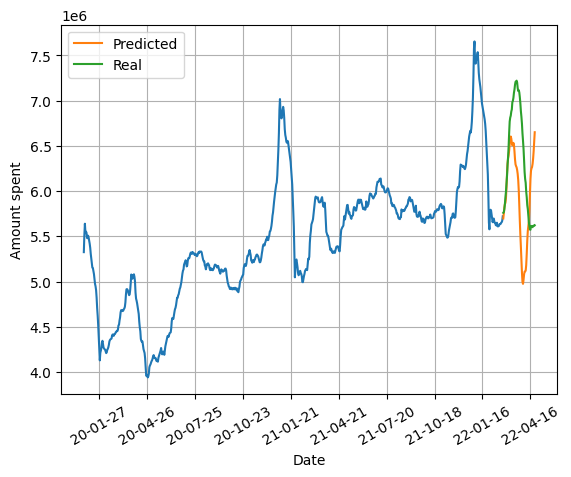

10.2


In [16]:
x0, fwd, smwin, value, dshift  = 1487, 60, 28, 'survival', 700
dat=data[value].rolling(smwin).mean().dropna().values
y=MSSAUse(dat[x0-700:x0], fwd, prds=[], predictors=None)
x=np.arange(x0, x0+fwd)-dshift
xt=np.arange(smwin+dshift, x0+fwd+smwin, 90)-dshift
plt.plot(dat[dshift:x0])
plt.plot(x, y, label='Predicted')
plt.plot(x, dat[x0:x0+fwd], label='Real')
plt.xticks(xt, data.index.strftime('%y-%m-%d')[xt+dshift+smwin], rotation=30)
plt.xlabel('Date')
plt.ylabel('Amount spent')
plt.legend()
plt.grid()
#plt.savefig('MSSA_no_news22.png', dpi=600, pad_inches=0.1, facecolor='white')
#plt.savefig('MSSA_stationar.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
print(Metr(y, dat[x0:x0+fwd])[2].round(1))    

In [17]:
clmn=tpc.columns[:]
dat=data.rolling(smwin).mean().dropna()
data['week']=data.index.strftime('%Y-%m-%d') #[smwin-1:]data.rename(columns={value:'data'})[100:x0]
prds=ChoosePredsCCor(pd.DataFrame({'week':data.index[x0-300+fwd:x0+fwd].strftime('%Y-%m-%d'), 'data':dat[value][x0-300:x0]}), tpc[clmn].rename(columns={'date':'week'})[x0-300:x0], len(c), maxlag=15)

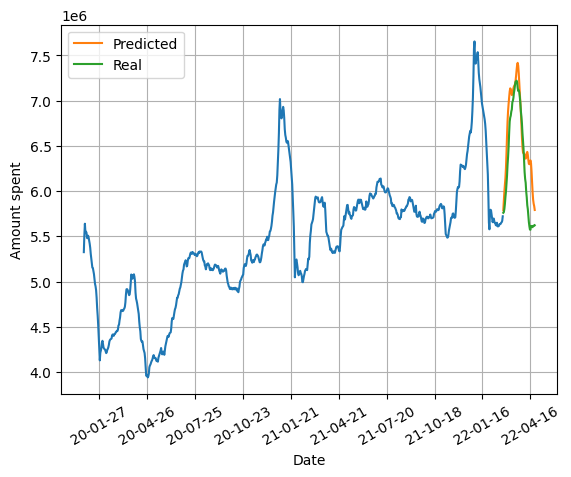

4.6


In [18]:
dat=data[value].rolling(smwin).mean().dropna().values
y=MSSAUse(dat[x0-700:x0], fwd, prds=prds[5:7], predictors=tpc[x0-700:x0])
x=np.arange(x0, x0+fwd)-dshift
xt=np.arange(smwin+dshift, x0+fwd+smwin, 90)-dshift
plt.plot(dat[dshift:x0])
plt.plot(x, y, label='Predicted')
plt.plot(x, dat[x0:x0+fwd], label='Real')
plt.xticks(xt, data.index.strftime('%y-%m-%d')[xt+dshift+smwin], rotation=30)
plt.xlabel('Date')
plt.ylabel('Amount spent')
plt.legend()
plt.grid()
plt.savefig('MSSA_with_news22.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
print(Metr(y, dat[x0:x0+fwd])[2].round(1))